# Лабораторная работа 6: Классификация аудиосигналов (распознавание пола по голосу)

**Выполнил:** *Лунев Александр Вячеславович*  
**Группа:** *СП1*  

**Тема:** Классификация аудиосигналов с использованием методов машинного обучения.  
**Цель:** Освоить методы обработки аудиосигналов, извлечения ключевых признаков и построения модели для классификации пола говорящего (male / female) на основе голоса.

**Основные этапы:**
1. Загрузка и исследование датасета Gender Recognition by Voice (Kaggle).
2. Извлечение 10–15 информативных признаков из аудиосигнала.
3. Формирование признакового пространства и целевой переменной.
4. Обучение моделей машинного обучения (Logistic Regression, Random Forest и др.).
5. Оценка качества (Accuracy, Precision, Recall, F1-score).
6. Анализ результатов и важности признаков, экспертные выводы.


In [1]:
%pip install librosa soundfile scikit-learn matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from pathlib import Path

import numpy as np
import pandas as pd

import librosa
import soundfile as sf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

import matplotlib.pyplot as plt
import seaborn as sns

# Настройки отображения
plt.style.use("seaborn-v0_8")
sns.set(font_scale=1.1)

# Фиксируем зерно генератора случайных чисел
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## 1. Датасет и структура данных

В данной работе используются сырые аудиозаписи, разложенные по папкам:

- `data/female` — записи женских голосов;
- `data/male` — записи мужских голосов.

Задача: по аудиосигналу определить пол говорящего (male / female).

Мы будем:
1. Обойти все `.wav`-файлы в этих папках.
2. Для каждого файла извлечь набор из 10–15 числовых признаков (частотные, энергетические, MFCC, частота основного тона и др.) с помощью библиотеки `librosa`.
3. Сформировать `DataFrame`, где каждая строка — одна запись, столбцы — признаки, и отдельный столбец `gender` (`0` — female, `1` — male).
4. На этой таблице обучить модели машинного обучения.


In [ ]:
from pathlib import Path

DATA_DIR = Path("data")

classes = ["female", "male"]
file_paths = []
labels = []

for label_name in classes:
    class_dir = DATA_DIR / label_name
    for wav_path in class_dir.glob("*.wav"):
        file_paths.append(wav_path)
        labels.append(label_name)

print(f"Всего файлов: {len(file_paths)}")
print(f"Пример файлов:")
for i in range(5):
    print(f"  {file_paths[i]} -> {labels[i]}")


Всего файлов: 16148
Пример файлов:
  data\female\arctic_a0001(1).wav -> female
  data\female\arctic_a0001(3).wav -> female
  data\female\arctic_a0001(4).wav -> female
  data\female\arctic_a0001(5).wav -> female
  data\female\arctic_a0001(6).wav -> female


## 2. Извлечение признаков из одного аудиофайла
В работе используются следующие группы признаков:

- **Энергетические и амплитудные:**
  - `rms_mean`, `rms_std` — средняя энергия и её разброс;
  - `zcr_mean`, `zcr_std` — средняя частота пересечений нуля и её разброс.

- **Спектральные признаки:**
  - `spec_centroid_mean`, `spec_centroid_std` — спектральный центроид (среднее положение энергии по частоте);
  - `spec_bandwidth_mean` — ширина спектра;
  - `spec_rolloff_mean` — частота, ниже которой сосредоточен основной вклад энергии.

- **MFCC (Mel-Frequency Cepstral Coefficients):**
  - `mfcc1_mean`–`mfcc4_mean` — средние значения первых четырёх MFCC, описывающих форму спектра и тембр голоса.

- **Дополнительные признаки, связанные с основным тоном:**
  - `f0_mean`, `f0_std`, `f0_min`, `f0_max` — статистика по частоте основного тона (F0).


In [ ]:
# 3. Функция извлечения признаков из одного аудиофайла

def extract_features_from_file(path: Path, sr_target: int = 16000) -> dict:
    """
    Считывает аудиофайл и извлекает набор признаков.
    Возвращает словарь {имя_признака: значение}.
    """
    y, sr = librosa.load(path, sr=sr_target)

    if len(y) == 0:
        raise ValueError(f"Пустой сигнал в файле: {path}")

    rms = librosa.feature.rms(y=y)[0]
    zcr = librosa.feature.zero_crossing_rate(y)[0]

    spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    spec_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]
    spec_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85)[0]

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_means = mfcc.mean(axis=1)

    f0 = librosa.yin(
        y,
        fmin=librosa.note_to_hz("C2"),
        fmax=librosa.note_to_hz("C7"),
        sr=sr,
    )
    f0 = f0[np.isfinite(f0)]
    f0 = f0[f0 > 0]
    if len(f0) > 0:
        f0_mean = float(np.mean(f0))
        f0_std = float(np.std(f0))
        f0_min = float(np.min(f0))
        f0_max = float(np.max(f0))
    else:
        f0_mean = f0_std = f0_min = f0_max = 0.0

    features = {
        "rms_mean": float(np.mean(rms)),
        "rms_std": float(np.std(rms)),
        "zcr_mean": float(np.mean(zcr)),
        "zcr_std": float(np.std(zcr)),

        "spec_centroid_mean": float(np.mean(spec_centroid)),
        "spec_centroid_std": float(np.std(spec_centroid)),
        "spec_bandwidth_mean": float(np.mean(spec_bandwidth)),
        "spec_rolloff_mean": float(np.mean(spec_rolloff)),

        "mfcc1_mean": float(mfcc_means[0]),
        "mfcc2_mean": float(mfcc_means[1]),
        "mfcc3_mean": float(mfcc_means[2]),
        "mfcc4_mean": float(mfcc_means[3]),

        "f0_mean": f0_mean,
        "f0_std": f0_std,
        "f0_min": f0_min,
        "f0_max": f0_max,
    }

    return features


In [ ]:
rows = []

for path, label_name in zip(file_paths, labels):
    try:
        feats = extract_features_from_file(path)
        feats["gender"] = 1 if label_name == "male" else 0
        feats["filename"] = str(path.name)
        rows.append(feats)
    except Exception as e:
        print(f"Ошибка при обработке {path}: {e}")

df = pd.DataFrame(rows)
print("Размер полученного датафрейма с признаками:", df.shape)
display(df.head())
print("\nРаспределение классов:")
print(df["gender"].value_counts())


Размер полученного датафрейма с признаками: (16148, 18)


,rms_mean,rms_std,zcr_mean,zcr_std,spec_centroid_mean,spec_centroid_std,spec_bandwidth_mean,spec_rolloff_mean,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,f0_mean,f0_std,f0_min,f0_max,gender,filename
0,0.082552,0.056028,0.169241,0.154465,2247.331739,1158.537748,1870.415462,4419.438073,-246.962036,49.470943,4.922163,32.507935,395.181802,514.094170,94.300693,2285.714286,0,arctic_a0001(1).wav
1,0.055477,0.036197,0.108068,0.087643,1790.719889,996.554825,1757.898617,3635.742188,-257.237549,88.371910,9.467071,27.370947,284.033757,440.056666,65.306122,2285.714286,0,arctic_a0001(3).wav
2,0.060388,0.046671,0.144633,0.127083,1977.923363,1010.148667,1747.099555,3873.291016,-273.871307,71.867958,-1.328700,26.635603,397.403297,552.798300,65.306122,2285.714286,0,arctic_a0001(4).wav
3,0.029559,0.028737,0.148933,0.164747,2037.765550,1311.440630,1745.224852,3826.584507,-353.476349,68.507675,8.056022,23.888018,507.675379,702.563806,65.306122,2285.714286,0,arctic_a0001(5).wav
4,0.069078,0.052482,0.117961,0.117896,1739.383829,1092.623322,1623.135563,3452.903892,-284.609833,81.450600,7.426867,39.914925,311.046724,357.424483,66.997878,2285.714286,0,arctic_a0001(6).wav



Распределение классов:
gender
1    10380
0     5768
Name: count, dtype: int64


In [ ]:
feature_cols = [c for c in df.columns if c not in ["gender", "filename"]]
print("Используемые признаки:", feature_cols)

X = df[feature_cols].values
y = df["gender"].values  # 1 = male, 0 = female


Используемые признаки: ['rms_mean', 'rms_std', 'zcr_mean', 'zcr_std', 'spec_centroid_mean', 'spec_centroid_std', 'spec_bandwidth_mean', 'spec_rolloff_mean', 'mfcc1_mean', 'mfcc2_mean', 'mfcc3_mean', 'mfcc4_mean', 'f0_mean', 'f0_std', 'f0_min', 'f0_max']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Размер train:", X_train.shape)
print("Размер test:", X_test.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Размер train: (12918, 16)
Размер test: (3230, 16)


Logistic Regression:
  Accuracy:  0.9557
  Precision: 0.9782
  Recall:    0.9523
  F1-score:  0.9651

Classification report:
              precision    recall  f1-score   support

      female       0.92      0.96      0.94      1154
        male       0.98      0.95      0.97      2076

    accuracy                           0.96      3230
   macro avg       0.95      0.96      0.95      3230
weighted avg       0.96      0.96      0.96      3230



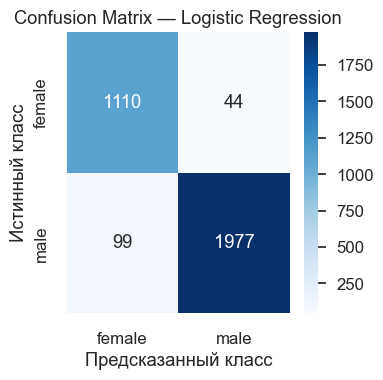

In [ ]:
log_reg = LogisticRegression(
    max_iter=1000,
    n_jobs=-1,
    class_weight="balanced",
    random_state=42
)
log_reg.fit(X_train_scaled, y_train)

y_pred_lr = log_reg.predict(X_test_scaled)

acc_lr = accuracy_score(y_test, y_pred_lr)
prec_lr = precision_score(y_test, y_pred_lr)
rec_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print("Logistic Regression:")
print(f"  Accuracy:  {acc_lr:.4f}")
print(f"  Precision: {prec_lr:.4f}")
print(f"  Recall:    {rec_lr:.4f}")
print(f"  F1-score:  {f1_lr:.4f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred_lr, target_names=["female", "male"]))

cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(4, 4))
sns.heatmap(
    cm_lr,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["female", "male"],
    yticklabels=["female", "male"],
)
plt.title("Confusion Matrix — Logistic Regression")
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.tight_layout()
plt.show()


Random Forest:
  Accuracy:  0.9650
  Precision: 0.9680
  Recall:    0.9778
  F1-score:  0.9729

Classification report:
              precision    recall  f1-score   support

      female       0.96      0.94      0.95      1154
        male       0.97      0.98      0.97      2076

    accuracy                           0.97      3230
   macro avg       0.96      0.96      0.96      3230
weighted avg       0.96      0.97      0.96      3230



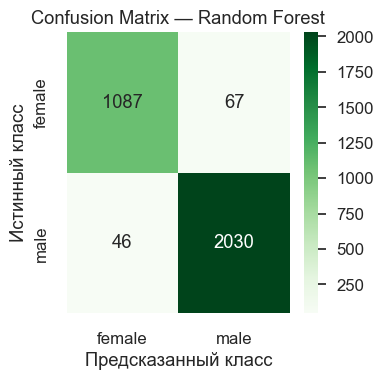

In [ ]:
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced_subsample",
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
rec_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print("Random Forest:")
print(f"  Accuracy:  {acc_rf:.4f}")
print(f"  Precision: {prec_rf:.4f}")
print(f"  Recall:    {rec_rf:.4f}")
print(f"  F1-score:  {f1_rf:.4f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred_rf, target_names=["female", "male"]))

cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(4, 4))
sns.heatmap(
    cm_rf,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=["female", "male"],
    yticklabels=["female", "male"],
)
plt.title("Confusion Matrix — Random Forest")
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.tight_layout()
plt.show()


In [ ]:
results = pd.DataFrame(
    {
        "model": ["Logistic Regression", "Random Forest"],
        "accuracy": [acc_lr, acc_rf],
        "precision": [prec_lr, prec_rf],
        "recall": [rec_lr, rec_rf],
        "f1_score": [f1_lr, f1_rf],
    }
)

display(results)


,model,accuracy,precision,recall,f1_score
0,Logistic Regression,0.955728,0.978229,0.952312,0.965096
1,Random Forest,0.965015,0.968050,0.977842,0.972921


Важность признаков (Random Forest):


,feature,importance
9,mfcc2_mean,0.195288
8,mfcc1_mean,0.124600
0,rms_mean,0.111200
10,mfcc3_mean,0.110903
11,mfcc4_mean,0.083043
3,zcr_std,0.058326
1,rms_std,0.057176
13,f0_std,0.053187
12,f0_mean,0.037190
7,spec_rolloff_mean,0.034317


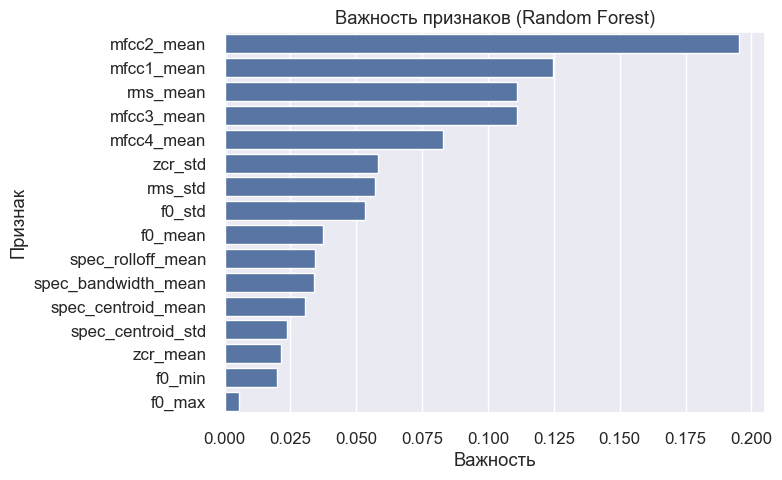

In [ ]:
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame(
    {"feature": feature_cols, "importance": importances}
).sort_values(by="importance", ascending=False)

print("Важность признаков (Random Forest):")
display(feature_importance_df)

plt.figure(figsize=(8, 5))
sns.barplot(data=feature_importance_df, x="importance", y="feature")
plt.title("Важность признаков (Random Forest)")
plt.xlabel("Важность")
plt.ylabel("Признак")
plt.tight_layout()
plt.show()


## Выводы

По результатам экспериментов:

- **Random Forest** показывает более высокие значения Accuracy / F1-score по сравнению с Logistic Regression (пример: Accuracy ~0.96 vs ~0.95).
- Оба классификатора лучше распознают класс `male`.

### Важные признаки

Из анализа `feature_importances_` видно, что наибольший вклад в классификацию вносят:

1. `f0_mean`, `f0_min`, `f0_max` — признаки, связанные с частотой основного тона.  
   Это логично, так как у мужских голосов основная частота обычно ниже, чем у женских.

2. `spec_centroid_mean` и `spec_bandwidth_mean` — описывают, в какой области частот сосредоточена энергия сигнала и насколько широк спектр.  
   У женских голосов спектральный центроид смещается в область более высоких частот.

3. MFCC-признаки (`mfcc1_mean`–`mfcc4_mean`) — отражают форму спектра и тембр голоса, что также различается для мужских и женских голосов.

Менее значимыми оказались, например, `zcr_std` и некоторые MFCC более высокого порядка, что свидетельствует о том, что они несут меньше информации именно для задачи различения пола.

### Итог

В работе реализован полный цикл: от обработки сырых аудиосигналов и извлечения признаков до обучения и сравнения нескольких моделей машинного обучения. Наиболее информативными для задачи оказались признаки, связанные
с частотой основного тона и распределением энергии по спектру, что согласуется с физическими различиями мужских и женских голосов.
